# Team Information

Project Title: Data Analysis on the Pokémon Pokedex

Team Name: Team 6

Member Names w/ PIDs: Rohan Jaggannagari (rjaggannagari), Jayanth Kalidindi (jayk21), Luke Hylton (lnhylton), Markus Homann (homann), Aniket Sonnakul (anikets)

# Contributions

Rohan Jaggannagari: Cleaned up and merged the datasets from Kaggle, PCA analysis/clustering/distance matrix on legendary Pokemon, correlation matrix for each base stat and generation, recomendation system

Jayanth Kalidindi: Helped clean up and merge datasets and write/build recommendation system with sliders. 

Luke Hylton: Wrote code and implemented weighted sliders section.

Markus Homann: Worked on the report, analysis of Legendary data with respect to similarity between one another, and worked on the PCA analysis/ Clustering 

Aniket Sonnakul: Helped clean dataset and analyze categorical data, and write QAC descriptions on report.

## Using Data Science to Analyze Pokemon Data

To answer this question, first we need to define the data collected. The primary dataset consists of each pokemon 'from' Generations '1-7' 'with' their characteristics.

The different characteristics of Pokemon that we are going to be looking at are: Name, Type1,Type2, Hp, Attack, Defense, Special Attack, Special Defense, Speed, Against Poison, Against Psychic, Against Rock, Against Steel, Against Water, Capture Rate, Experience Growth, Height (M), Percentage Male, Weight (Kg). 

The additional dataset shows each Pokemon’s abilities and how their types match up against other types. 


First we import several modules that will be used to extract, clean, and visualize the data, and then read in the datasets:

## Imports

In [1]:
import pandas
import numpy
import IPython
import sklearn.metrics.pairwise
import sklearn.cluster
import sklearn.decomposition
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, clear_output

## Reading in data

In [2]:
# Read in the data
pokemon_data_df = pandas.read_csv('pokemon_data.csv')
pokemon_abilities_df = pandas.read_csv('pokemon_abilities.csv')

# Output the shape of the data
print("Shape of first dataset is " + str(pokemon_data_df.shape))
print("Shape of second dataset is " + str(pokemon_abilities_df.shape))

Shape of first dataset is (800, 12)
Shape of second dataset is (801, 41)


The data sets are cleaned for specific cases and then merged into a single dataframe.

## Merge both datasets and then clean them

In [3]:
# Some Pokemon in each dataset were named differently so I fixed it
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Ho-oh', 'Name'] = 'Ho-Oh'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Landorus Therian Forme', 'Name'] = 'Landorus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Tornadus Therian Forme', 'Name'] = 'Tornadus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Thundurus Therian Forme', 'Name'] = 'Thundurus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Hoopa Confined', 'Name'] = 'Hoopa'

# Move the name column to all the way to the left
if "name" in pokemon_abilities_df.columns:
    move_name = pokemon_abilities_df.pop('name')
    pokemon_abilities_df.insert(0, 'Name', move_name)

# Merged the two datasets and now have to clean it up so it is more readable
pokemon_df = pandas.merge(pokemon_data_df, pokemon_abilities_df, on = 'Name', how = 'inner', indicator = True)
pokemon_df = pokemon_df[pokemon_df['_merge'] == 'both']

# We do not care about megas so the data from the second dataset number is better to index by
move_pokedex_number = pokemon_df.pop('pokedex_number')
pokemon_df.insert(0, 'Pokedex Number', move_pokedex_number)

# Gets rid of the columns we are not using and the duplicates
pokemon_df = pokemon_df.drop(['#', 'attack', 'base_egg_steps', 'base_happiness', 'base_total', 'classfication', 'defense', 'hp', 'japanese_name', 'sp_attack','sp_defense','speed','type1','type2','generation','is_legendary', '_merge'], axis = 1)

# Format the names to be more uniform
pokemon_df.columns = [underscore_rem.replace('_', ' ') for underscore_rem in pokemon_df.columns]
pokemon_df.columns = [caps.title() for caps in pokemon_df.columns]

pokemon_df.head(15)

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,2.0,1.0,1.0,0.5,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,2.0,1.0,1.0,0.5,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,2.0,1.0,1.0,0.5,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,2.0,0.5,2.0,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,2.0,0.5,2.0,45,1059860,1.1,88.1,19.0
5,6,Charizard,Fire,Flying,78,84,78,109,85,100,...,1.0,1.0,4.0,0.5,2.0,45,1059860,1.7,88.1,90.5
6,7,Squirtle,Water,NaN,44,48,65,50,64,43,...,1.0,1.0,1.0,0.5,0.5,45,1059860,0.5,88.1,9.0
7,8,Wartortle,Water,NaN,59,63,80,65,80,58,...,1.0,1.0,1.0,0.5,0.5,45,1059860,1.0,88.1,22.5
8,9,Blastoise,Water,NaN,79,83,100,85,105,78,...,1.0,1.0,1.0,0.5,0.5,45,1059860,1.6,88.1,85.5
9,10,Caterpie,Bug,NaN,45,30,35,20,20,45,...,1.0,1.0,2.0,1.0,1.0,255,1000000,0.3,50.0,2.9


# Pokemon Recomendation System

We want to find a Pokemon that has a high stat in a category that is lacking in the current lineup. This is also useful for if we want to find a similar Pokemon to one in our squad but of a different type.

Each slider has a minimum value of 1 and a maximum value of 99 that can be chosen by the user. With the desired traits at their values, the recommendation system will rank Pokemons that are closest to the user’s inputs. 

### What Pokemon have the most similar statistics?

## Similarity Sliders

In [4]:
# Making the sliders for each stat
hp_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'HP:', description_width = 'auto')
hp_slider.layout.width = '75%'
attack_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Attack:', description_width = 'auto')
attack_slider.layout.width = '75%'
defense_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Defense:', description_width = 'auto')
defense_slider.layout.width = '75%'
sp_attack_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Sp. Attack:', description_width = 'auto')
sp_attack_slider.layout.width = '75%'
sp_defense_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Sp. Defense:', description_width = 'auto')
sp_defense_slider.layout.width = '75%'
speed_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Speed:', description_width = 'auto')
speed_slider.layout.width = '75%'

print("\n" + "Set the sliders to the desired amount and the code below will output Pokemon that are most similar" + "\n")
display(hp_slider, attack_slider, defense_slider, sp_attack_slider, sp_defense_slider, speed_slider)
print("\n" + "Note: These values are going to be used as %'s")


Set the sliders to the desired amount and the code below will output Pokemon that are most similar



IntSlider(value=1, description='HP:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Attack:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Defense:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Sp. Attack:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Sp. Defense:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Speed:', layout=Layout(width='75%'), max=99, min=1)


Note: These values are going to be used as %'s


In [5]:
pokemon_df

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,2.0,1.0,1.00,0.5,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,2.0,1.0,1.00,0.5,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,2.0,1.0,1.00,0.5,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,2.0,0.50,2.0,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,2.0,0.50,2.0,45,1059860,1.1,88.1,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,716,Xerneas,Fairy,NaN,126,131,95,131,98,99,...,2.0,1.0,1.0,2.00,1.0,45,1250000,3.0,NaN,215.0
704,717,Yveltal,Dark,Flying,126,131,95,131,98,99,...,1.0,0.0,2.0,1.00,1.0,45,1250000,5.8,NaN,203.0
705,719,Diancie,Rock,Fairy,50,100,150,100,150,50,...,1.0,1.0,1.0,4.00,2.0,3,1250000,0.7,NaN,8.8
706,720,Hoopa,Psychic,Ghost,80,110,60,150,130,70,...,0.5,0.5,1.0,1.00,1.0,3,1250000,NaN,NaN,NaN


In [6]:
# Only account for the stats
pokemon_rec = pokemon_df[['Name', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
pokemon_rec = pokemon_rec.set_index('Name')

# Get all of the maxes for all the stats
hp_max = pokemon_rec['Hp'].max()
attack_max = pokemon_rec['Attack'].max()
defense_max = pokemon_rec['Defense'].max()
sp_attack_max = pokemon_rec['Sp. Atk'].max()
sp_defense_max = pokemon_rec['Sp. Def'].max()
speed_max = pokemon_rec['Speed'].max()

# Based on the slider
hp_value = (hp_slider.value * (hp_max - 1))/100
attack_value = (attack_slider.value * (attack_max - 5))/100
defense_value = (defense_slider.value * (defense_max - 5))/100
sp_attack_value = (sp_attack_slider.value * (sp_attack_max - 10))/100
sp_defense_value = (sp_defense_slider.value * (sp_defense_max - 20))/100
speed_value = (speed_slider.value * (speed_max - 5))/100

# Uses the inputs to find most similar
inputs = numpy.array([hp_value, attack_value, defense_value, sp_attack_value, sp_defense_value, speed_value]).reshape(1, -1)
euc_dist = sklearn.metrics.pairwise.euclidean_distances(pokemon_rec.values, inputs)

# Sorts the dataframe
euc_dist_df = pandas.DataFrame(euc_dist, index = pokemon_rec.index, columns = ['Distance'])
euc_dist_df = euc_dist_df.sort_values('Distance')

rankings = pandas.DataFrame(euc_dist_df.index)
rankings_with_stats = pandas.merge(rankings, pokemon_rec, on = 'Name', how = 'inner')
rankings_with_stats.index.name = "Rankings"
rankings_with_stats.head(15)

,Name,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed
Rankings,,,,,,,
0,Sunkern,30,30,30,30,30,30
1,Kricketot,37,25,41,25,41,25
2,Scatterbug,38,35,40,27,25,35
3,Azurill,50,20,40,20,40,20
4,Ralts,28,25,25,45,35,40
5,Wurmple,45,45,35,20,30,20
6,Caterpie,45,30,35,20,20,45
7,Weedle,40,35,30,20,20,50
8,Tyrogue,35,35,35,35,35,35


## Ability Weights Sliders

#### Gather columns and clean data for weighting

In [7]:
pokemon_weights_rec = pokemon_df[['Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
pokemon_weights_rec = pokemon_weights_rec.set_index(pokemon_df.Name)
pokemon_weights_rec = pokemon_weights_rec.fillna(0).astype("int64")
normalized_pokemon = (pokemon_weights_rec - pokemon_weights_rec.mean()) / pokemon_weights_rec.std()

#### Weight the data according the weights recieved in function

In [8]:
def weight_data(dataHD, wts): # dataHD, wts -> data2D (pandas)
    # Normalize the weights to sum to 1
    wts = wts/wts.sum()
    
    # Apply weights to the HD data 
    dataHDw = pandas.DataFrame(dataHD * wts)

    # Compute row relevances as:  data dot weights
    # High relevance means large values in upweighted dimensions
    dataHDw['relevance'] = dataHDw.sum(axis=1)
    return dataHDw

min_weight, max_weight = 0.00001, 0.9999
init_weight = min_weight  # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
weights = pandas.Series(init_weight, index=normalized_pokemon.columns, name="Weight")  # the current weight list

df_2D = weight_data(normalized_pokemon, weights)   # the current projected data

#### Create sliders for weighing data according to users preferences

In [9]:
def create_sliders(wts):
    # Create sliders, one for each dimension weight
    sliders = [widgets.FloatSlider(min=min_weight, max=max_weight, step=0.01, value=value, 
                                       description=label, continuous_update=False, readout_format='.5f')
                   for (label, value) in wts.iteritems()]
    # Display sliders
    for s in sliders:
        #s.observe(sliderchange, names='value')
        display(s)
        
    create_slider_buttons(sliders)
    return sliders

def create_slider_buttons(sliders):    
    apply_button = widgets.Button(description='Apply Slider Weights')
    reset_button = widgets.Button(description='Reset Weights')
    
    output = widgets.Output()
    with output:
        display()

    # Callback functions
    def apply_button_clicked(change):
        # Use the slider values to recompute the DR and redraw the plot
        global weights, df_2D   # Update weights and df_2D globals
        weights = pandas.Series([s.value for s in sliders], index=normalized_pokemon.columns, name='Weight')
        df_2D = weight_data(normalized_pokemon, weights)
    
        display_data(df_2D)
    apply_button.on_click(apply_button_clicked)

    def reset_button_clicked(change):
        # Reset all sliders to initial value and recompute DR and redraw the plot
        for s in sliders:
            s.value = init_weight
        apply_button_clicked(change)
    reset_button.on_click(reset_button_clicked)
    
    def display_data(data):
        data = data.sort_values("relevance", ascending=False)
        rankings = pandas.DataFrame(data.index)
        rankings_with_stats = pandas.merge(rankings, pokemon_weights_rec, on = 'Name', how = 'inner')
        rankings_with_stats.index.name = "Rankings"

        # Reoutput the rankings
        with output:
            output.clear_output()
            display(rankings_with_stats.head(25))
    
    # Display buttons
    display(apply_button)
    display(reset_button)
    display(output)
    return apply_button, reset_button

#### Creates sliders

In [10]:
sliders = create_sliders(weights)

FloatSlider(value=1e-05, continuous_update=False, description='Hp', max=0.9999, min=1e-05, readout_format='.5f…

FloatSlider(value=1e-05, continuous_update=False, description='Attack', max=0.9999, min=1e-05, readout_format=…

FloatSlider(value=1e-05, continuous_update=False, description='Defense', max=0.9999, min=1e-05, readout_format…

FloatSlider(value=1e-05, continuous_update=False, description='Sp. Atk', max=0.9999, min=1e-05, readout_format…

FloatSlider(value=1e-05, continuous_update=False, description='Sp. Def', max=0.9999, min=1e-05, readout_format…

FloatSlider(value=1e-05, continuous_update=False, description='Speed', max=0.9999, min=1e-05, readout_format='…

Button(description='Apply Slider Weights', style=ButtonStyle())

Button(description='Reset Weights', style=ButtonStyle())

Output()

# Working with Legendary Pokemon data

## Clustering legendary Pokemon based on their base statistics, clusters

In [11]:
# Makes a cluster slider
cluster_slider = widgets.IntSlider(value = 1, min = 1, max = 42, step = 1, description = 'Clusters:', description_width='auto')
cluster_slider.layout.width = '75%'
display(cluster_slider)

IntSlider(value=1, description='Clusters:', layout=Layout(width='75%'), max=42, min=1)

C:\Users\anike\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\anike\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

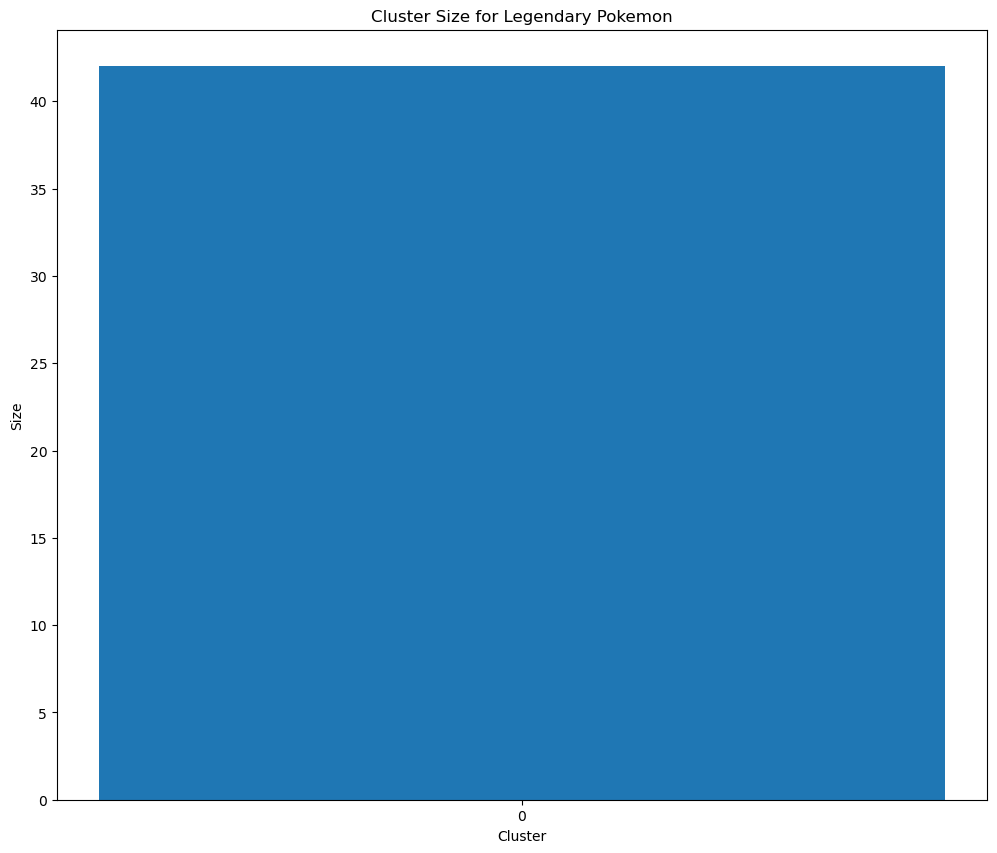

In [30]:
# Makes a copy of the data from above
legendary_df = pokemon_df.copy()

# Filters based on whether it is legendary or not
legendary_df = legendary_df[legendary_df['Legendary']]

# Only use columns with statistics
legendary_df = legendary_df.iloc[:, [1, 4, 5, 6, 7, 8, 9]]

# Get rid of the index and reset it to the name
legendary_df = legendary_df.reset_index()
legendary_df = legendary_df.drop(['index'], axis = 1)
legendary_df = legendary_df.set_index('Name')

# Normalize the data
legendary_df = (legendary_df - legendary_df.mean())/legendary_df.std()

# Clustering the data into a specfic amount of clusters
specfic_clusters = sklearn.cluster.KMeans(n_clusters = cluster_slider.value)
specfic_clusters.init = legendary_df.iloc[:cluster_slider.value,:]
cluster_df = specfic_clusters.fit_predict(legendary_df)

# Puts the data into a dataframe
clustered_legendary = pandas.DataFrame(cluster_df, columns = ['Cluster'], index = legendary_df.index)
clustered_legendary = clustered_legendary.sort_values('Cluster')

# Dataframe to show size per cluster
cluster_size = numpy.bincount(clustered_legendary['Cluster'])
cluster_total_df = pandas.DataFrame({'Size': cluster_size})
cluster_total_df = cluster_total_df.reset_index().rename(columns={'index': 'Cluster'})

# Bar chart to show cluster size
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(cluster_total_df['Cluster'], cluster_total_df['Size'])
plt.xticks(cluster_total_df.index, cluster_total_df.index)
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Cluster Size for Legendary Pokemon')
plt.show

## PCA analysis on legendary Pokemon, PCA

<function matplotlib.pyplot.show(close=None, block=None)>

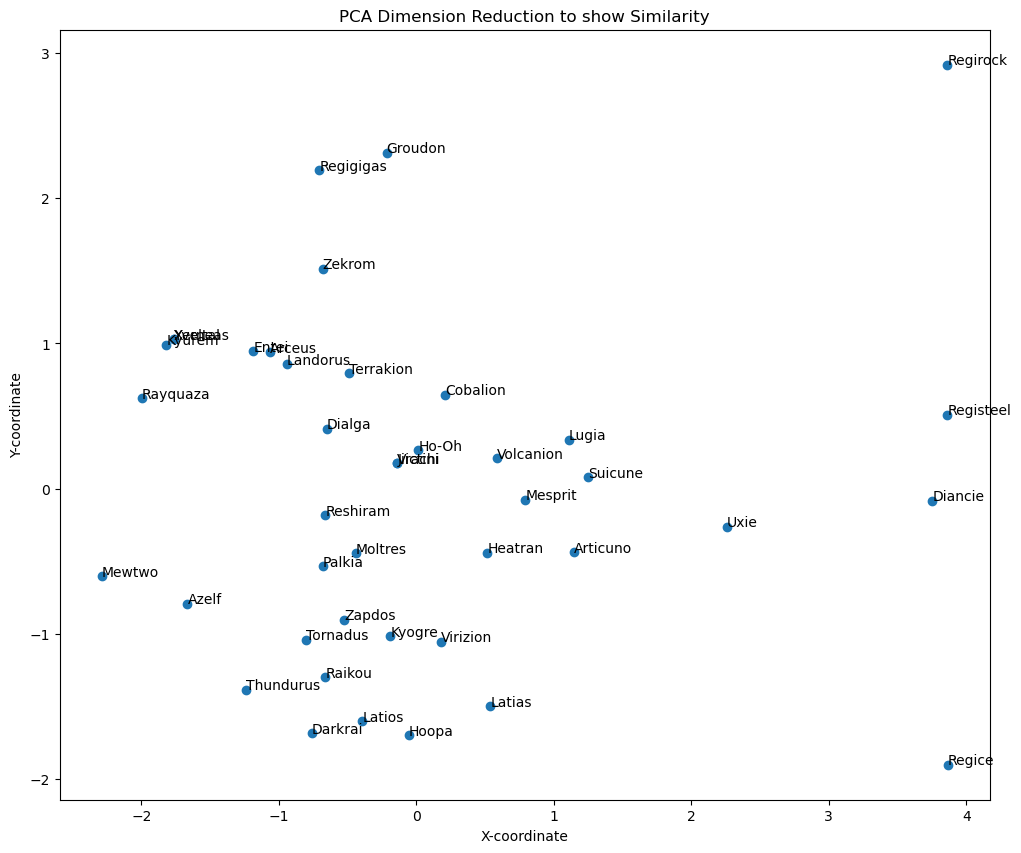

In [31]:
# Now lets find the location of each legendary Pokemon
pca = sklearn.decomposition.PCA(n_components = 2, svd_solver = 'full')
pca_model_data = pca.fit_transform(legendary_df)
pca_df = pandas.DataFrame(pca_model_data, index = legendary_df.index, columns = ['X', 'Y'])
pca_df = pca_df.sort_index()
pca_df = pca_df.reset_index()

# Used to graph
pokemon_names = pca_df.iloc[:, 0].tolist()
x_coords = pca_df.iloc[:, 1].tolist()
y_coords = pca_df.iloc[:, 2].tolist()

# Need to set the X and Y and the names
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(x_coords, y_coords)
for i in range (0, 42):
    ax.text(x_coords[i], y_coords[i], pokemon_names[i])
    
# Labels for the scatter plot
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_title('PCA Dimension Reduction to show Similarity')

# Show the graph
plt.show

We want to visualize if there are any strong correlations between Pokemon attributes.

# How do different statistics correlate to others all Pokemon, linear regression

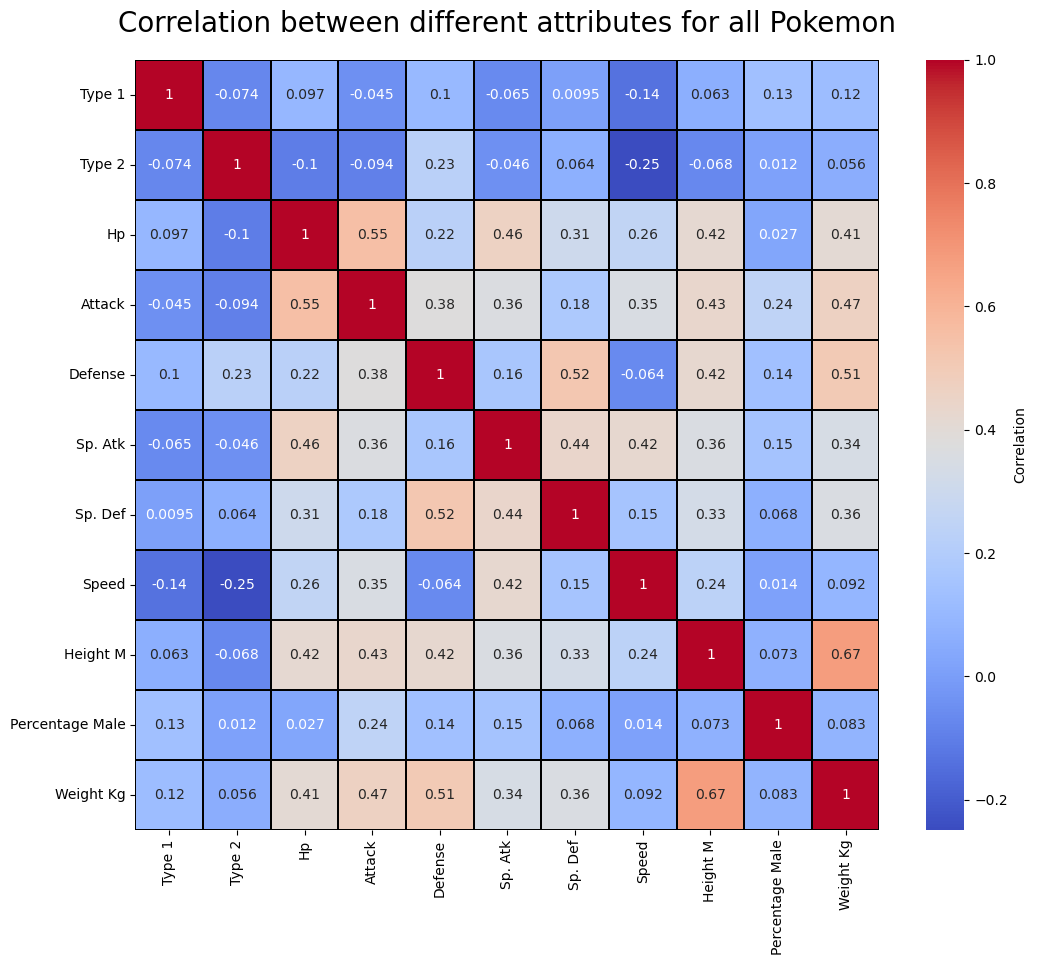

In [14]:
# Need to get rid of the data not being used in this part
corr_stats = pokemon_df.copy()
corr_stats = corr_stats[['Name', 'Type 1', 'Type 2', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height M', 'Percentage Male', 'Weight Kg']]
corr_stats = corr_stats.set_index('Name')

# Get rid of any NaN data in the weight and type 2
corr_stats = corr_stats.dropna(subset = ['Weight Kg', 'Type 2'])

# Encode the string
encode_string = LabelEncoder()
corr_stats['Type 1'] = encode_string.fit_transform(corr_stats['Type 1'])
corr_stats['Type 2'] = encode_string.fit_transform(corr_stats['Type 2'])

# Find correlations between 
corr_fin = corr_stats.corr()
plt.figure(figsize=(12, 10))
plt.title('Correlation between different attributes for all Pokemon', fontsize = 20, pad = 20)
sns.heatmap(corr_fin, annot = True, cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'}, linewidths = 0.25, linecolor = 'black')
plt.show()

In [15]:
corrTypes = pokemon_df.copy()
typeMean = pokemon_df.groupby('Type 1')['Attack'].mean()
typeMean

Type 1
Bug          65.322581
Dark         86.250000
Dragon      102.739130
Electric     67.500000
Fairy        61.529412
Fighting     94.291667
Fire         80.956522
Flying       66.666667
Ghost        63.850000
Grass        70.461538
Ground       91.966667
Ice          70.695652
Normal       71.673913
Poison       74.678571
Psychic      59.600000
Rock         88.463415
Steel        85.142857
Water        71.038462
Name: Attack, dtype: float64

In [16]:
corrTypes['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

# How do different statistics correlate over different generations, linear regression


In [17]:
gen_slider = widgets.IntSlider(value = 1, min = 1, max = 6, step = 1, description = 'Generation:', description_width='auto')
gen_slider.layout.width = '75%'
display(gen_slider)

IntSlider(value=1, description='Generation:', layout=Layout(width='75%'), max=6, min=1)

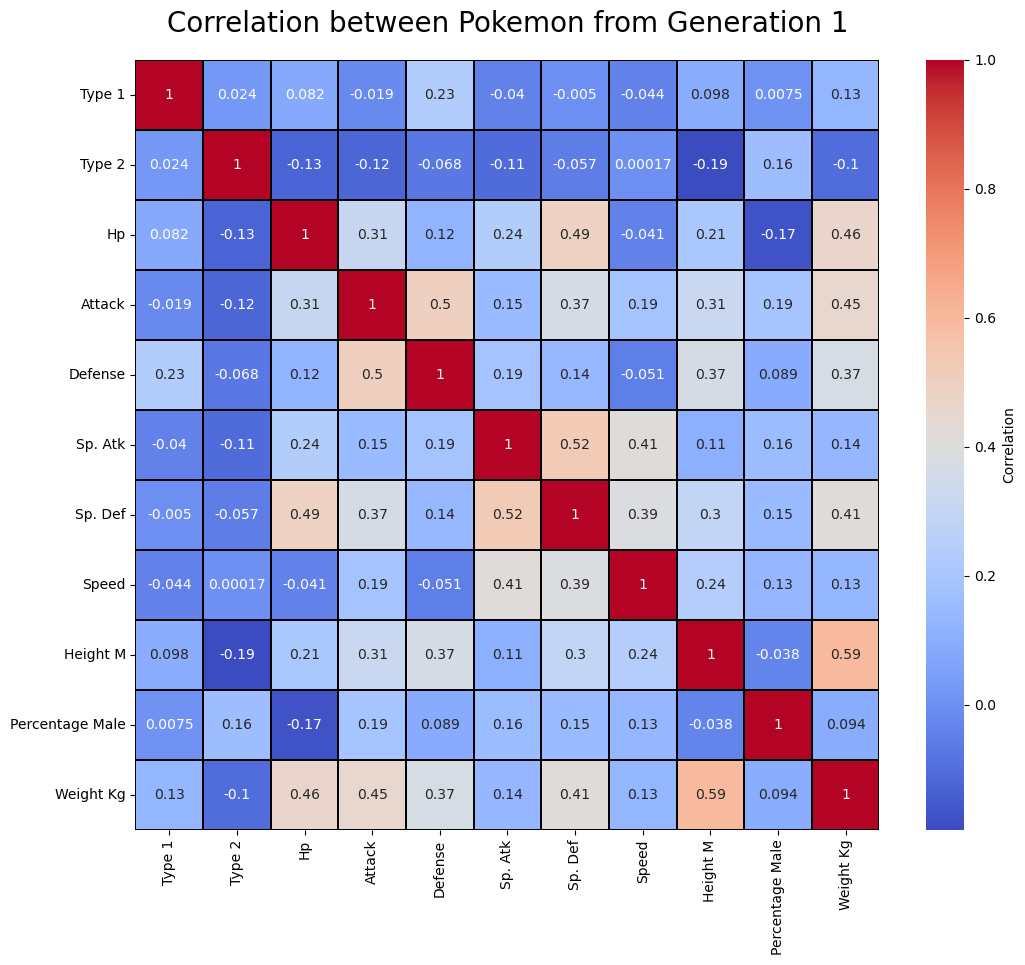

In [18]:
# Create a copy to not mess up previous dataset
generation_df = pokemon_df.copy()

# Only allows Pokemon from that generation
generation_df = generation_df[generation_df['Generation'] == gen_slider.value]
generation_corr_stats = generation_df[['Name', 'Type 1', 'Type 2', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height M', 'Percentage Male', 'Weight Kg']]
generation_corr_stats = generation_corr_stats.set_index('Name')

# Encode the string
encode_string = LabelEncoder()
generation_corr_stats['Type 1'] = encode_string.fit_transform(generation_corr_stats['Type 1'])
generation_corr_stats['Type 2'] = encode_string.fit_transform(generation_corr_stats['Type 2'])

# Find the correlation matrix
generation_corr_fin = generation_corr_stats.corr()

# Graph it
plt.figure(figsize=(12, 10))
plt.title('Correlation between Pokemon from Generation ' + str(gen_slider.value), fontsize = 20, pad = 20)
sns.heatmap(generation_corr_fin, annot = True, cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'}, linewidths = 0.25, linecolor = 'black')
plt.show()

## Visualizing distance matrix of legendary Pokemon, euclidean distances

In [19]:
# Find the euclidean distance for each legendary Pokemon and store it 
euc_dist_matrix = sklearn.metrics.pairwise.euclidean_distances(legendary_df)
euc_dist_matrix = pandas.DataFrame(euc_dist_matrix, index = legendary_df.index, columns = legendary_df.index)

numpy.fill_diagonal(euc_dist_matrix.values, numpy.NaN)
euc_dist_matrix

Name,Articuno,Zapdos,Moltres,Mewtwo,Raikou,Entei,Suicune,Lugia,Ho-Oh,Regirock,...,Thundurus,Reshiram,Zekrom,Landorus,Kyurem,Xerneas,Yveltal,Diancie,Hoopa,Volcanion
Name,,,,,,,,,,,,,,,,,,,,,
Articuno,0.000000,50.990195,53.385391,87.817994,50.497525,67.082039,23.452079,51.691392,58.923679,119.163753,...,78.752778,66.332496,77.459667,76.563699,76.811457,75.219678,75.219678,78.740079,74.833148,61.644140
Zapdos,50.990195,0.000000,15.811388,49.213819,23.452079,51.961524,57.445626,87.761039,79.385137,147.139390,...,32.741411,53.385391,71.763500,60.266077,53.851648,56.373753,56.373753,112.472219,65.192024,51.478151
Moltres,53.385391,15.811388,0.000000,53.122500,37.416574,47.958315,59.160798,91.334550,78.370913,140.178458,...,33.045423,49.497475,61.237244,49.517674,46.904158,50.675438,50.675438,107.935166,64.420494,39.370039
Mewtwo,87.817994,49.213819,53.122500,0.000000,54.332311,73.157365,92.908557,102.917443,89.621426,173.758453,...,46.647615,52.459508,73.430239,74.404301,50.616203,49.193496,49.193496,140.541809,82.413591,75.841941
Raikou,50.497525,23.452079,37.416574,54.332311,0.000000,55.677644,59.581876,82.897527,77.923039,156.204994,...,45.188494,64.807407,83.666003,70.014284,64.807407,65.787537,65.787537,120.000000,71.414284,71.414284
Entei,67.082039,51.961524,47.958315,73.157365,55.677644,0.000000,67.453688,95.247047,84.095184,139.283883,...,68.352030,78.740079,65.574385,43.954522,46.904158,51.845926,51.845926,130.000000,96.953597,72.111026
Suicune,23.452079,57.445626,59.160798,92.908557,59.581876,67.453688,0.000000,51.303021,75.046652,106.301458,...,88.724292,76.811457,82.462113,84.451169,81.240384,79.862382,79.862382,83.066239,93.273791,64.031242
Lugia,51.691392,87.761039,91.334550,102.917443,82.897527,95.247047,51.303021,0.000000,63.245553,117.439346,...,114.612390,83.618180,89.173987,104.766407,97.375562,90.796476,90.796476,85.743804,108.406642,92.043468
Ho-Oh,58.923679,79.385137,78.370913,89.621426,77.923039,84.095184,75.046652,63.245553,0.000000,147.621137,...,92.606695,54.699177,65.969690,77.562878,69.871310,63.906181,63.906181,96.705739,67.468511,82.897527


# Find the euclidean distance for each legendary Pokemon and store it


In [33]:
norm = (legendary_df - legendary_df.mean())/ legendary_df.std()
euc_dist_matrix = sklearn.metrics.pairwise.euclidean_distances(norm)
euc_dist_matrix = pandas.DataFrame(euc_dist_matrix, index = legendary_df.index, columns = legendary_df.index)

numpy.fill_diagonal(euc_dist_matrix.values, numpy.NaN)
euc_dist_matrix

Name,Articuno,Zapdos,Moltres,Mewtwo,Raikou,Entei,Suicune,Lugia,Ho-Oh,Regirock,...,Thundurus,Reshiram,Zekrom,Landorus,Kyurem,Xerneas,Yveltal,Diancie,Hoopa,Volcanion
Name,,,,,,,,,,,,,,,,,,,,,
Articuno,NaN,2.004027,2.045322,3.791242,2.170603,2.898416,1.031767,2.275138,2.485994,4.740479,...,3.116717,2.669292,3.174652,3.063274,3.487553,3.484991,3.484991,3.782581,2.992399,2.484728
Zapdos,2.004027,NaN,0.707657,2.301802,1.029461,2.375452,2.319917,3.431365,3.175838,5.910822,...,1.387592,2.170411,2.962140,2.483213,2.760169,2.861059,2.861059,4.996681,2.735616,2.285591
Moltres,2.045322,0.707657,NaN,2.567183,1.670976,2.253511,2.352099,3.609399,3.085898,5.565323,...,1.429704,1.966809,2.516589,2.026630,2.533587,2.682757,2.682757,4.736221,2.583707,1.726106
Mewtwo,3.791242,2.301802,2.567183,NaN,2.322507,3.030065,3.924447,3.991470,3.666958,7.306529,...,2.425320,2.422625,3.193674,3.299490,2.471697,2.388368,2.388368,6.595990,3.935326,3.753874
Raikou,2.170603,1.029461,1.670976,2.322507,NaN,2.549221,2.544473,3.245870,3.242154,6.393168,...,1.898917,2.721997,3.497032,2.947787,3.169612,3.205236,3.205236,5.435374,3.179722,3.181696
Entei,2.898416,2.375452,2.253511,3.030065,2.549221,NaN,2.782443,3.650301,3.211881,5.847769,...,3.177542,3.120376,2.691030,2.185255,1.894787,2.078163,2.078163,6.114230,4.201847,3.408304
Suicune,1.031767,2.319917,2.352099,3.924447,2.544473,2.782443,NaN,2.143038,3.003433,4.366089,...,3.622658,3.049496,3.375284,3.451102,3.470436,3.464411,3.464411,4.190821,3.790677,2.745555
Lugia,2.275138,3.431365,3.609399,3.991470,3.245870,3.650301,2.143038,NaN,2.590550,5.071980,...,4.569016,3.324079,3.592401,4.190202,3.896532,3.665465,3.665465,4.728821,4.561579,3.962962
Ho-Oh,2.485994,3.175838,3.085898,3.666958,3.242154,3.211881,3.003433,2.590550,NaN,5.955061,...,3.779063,2.115383,2.522979,3.032650,2.790530,2.615485,2.615485,4.821513,2.976165,3.460507


# Finding Legendary Pokemon Most Similar To Each Other

Now what if we want to find a pokemon most similar to a specific pokemon? We can use the distance matrix that we computed before to see which pokemon are closest together in. 

In [34]:
similar = pandas.DataFrame(euc_dist_matrix.idxmin())
similar = similar.rename(columns={0: "Most Similar To"})
similar


,Most Similar To
Name,
Articuno,Suicune
Zapdos,Moltres
Moltres,Zapdos
Mewtwo,Palkia
Raikou,Latios
Entei,Jirachi
Suicune,Articuno
Lugia,Suicune
Ho-Oh,Kyogre


As we can see, we have found the most similar pokemon for each legendary displayed in the table. We can use this information to find a similar legendary pokemon when trading or swapping out during battle.

In conclusion, we were able to use a normalized euclidean distance matrix to find most similar pokemon in regards to the five stats we have been working with.

In [20]:
pokemon_df.head(20)

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,2.0,1.0,1.0,0.5,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,2.0,1.0,1.0,0.5,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,2.0,1.0,1.0,0.5,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,2.0,0.5,2.0,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,2.0,0.5,2.0,45,1059860,1.1,88.1,19.0
5,6,Charizard,Fire,Flying,78,84,78,109,85,100,...,1.0,1.0,4.0,0.5,2.0,45,1059860,1.7,88.1,90.5
6,7,Squirtle,Water,NaN,44,48,65,50,64,43,...,1.0,1.0,1.0,0.5,0.5,45,1059860,0.5,88.1,9.0
7,8,Wartortle,Water,NaN,59,63,80,65,80,58,...,1.0,1.0,1.0,0.5,0.5,45,1059860,1.0,88.1,22.5
8,9,Blastoise,Water,NaN,79,83,100,85,105,78,...,1.0,1.0,1.0,0.5,0.5,45,1059860,1.6,88.1,85.5
9,10,Caterpie,Bug,NaN,45,30,35,20,20,45,...,1.0,1.0,2.0,1.0,1.0,255,1000000,0.3,50.0,2.9


In [36]:
multi = pokemon_df.copy()
filterCols = [col for col in pokemon_df.columns if col.startswith('Against')]
multi.loc[:, filterCols] = pokemon_df.loc[:, filterCols].apply(lambda x: 1 / x)
multi = multi.replace(numpy.inf, 0.0)
multi

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,0.5,1.0,1.00,2.0,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,0.5,1.0,1.00,2.0,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,0.5,1.0,1.00,2.0,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,0.5,2.00,0.5,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,0.5,2.00,0.5,45,1059860,1.1,88.1,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,716,Xerneas,Fairy,NaN,126,131,95,131,98,99,...,0.5,1.0,1.0,0.50,1.0,45,1250000,3.0,NaN,215.0
704,717,Yveltal,Dark,Flying,126,131,95,131,98,99,...,1.0,0.0,0.5,1.00,1.0,45,1250000,5.8,NaN,203.0
705,719,Diancie,Rock,Fairy,50,100,150,100,150,50,...,1.0,1.0,1.0,0.25,0.5,3,1250000,0.7,NaN,8.8
706,720,Hoopa,Psychic,Ghost,80,110,60,150,130,70,...,2.0,2.0,1.0,1.00,1.0,3,1250000,NaN,NaN,NaN
